# MNIST数据集使用LeNet进行图像分类
本示例教程演示如何在MNIST数据集上用LeNet进行图像分类。
手写数字的MNIST数据集，包含60,000个用于训练的示例和10,000个用于测试的示例。这些数字已经过尺寸标准化并位于图像中心，图像是固定大小(28x28像素)，其值为0到1。该数据集的官方地址为：http://yann.lecun.com/exdb/mnist/

## 环境
本教程基于paddle-develop编写，如果您的环境不是本版本，请先安装paddle-develop版本。

In [1]:
import paddle
print(paddle.__version__)
paddle.disable_static()

0.0.0


## 加载数据集
我们使用飞桨自带的paddle.dataset完成mnist数据集的加载。

In [3]:
print('download training data and load training data')
train_dataset = paddle.vision.datasets.MNIST(mode='train')
test_dataset = paddle.vision.datasets.MNIST(mode='test')
print('load finished')

download training data and load training data
load finished


取训练集中的一条数据看一下。

train_data0 label is: [5]


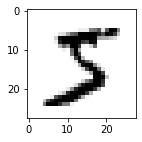

In [4]:
import numpy as np
import matplotlib.pyplot as plt
train_data0, train_label_0 = train_dataset[0][0],train_dataset[0][1]
train_data0 = train_data0.reshape([28,28])
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
print('train_data0 label is: ' + str(train_label_0))

## 组网
用paddle.nn下的API，如`Conv2d`、`Pool2D`、`Linead`完成LeNet的构建。

In [6]:
import paddle
import paddle.nn.functional as F
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2d(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, shape=[-1, 16*5*5])
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x)
        return x

## 训练方式一
组网后，开始对模型进行训练，先构建`train_loader`，加载训练数据，然后定义`train`函数，设置好损失函数后，按batch加载数据，完成模型的训练。

In [7]:
import paddle
train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载训练集 batch_size 设为 64
def train(model):
    model.train()
    epochs = 2
    optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    # 用Adam作为优化函数
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = paddle.nn.functional.cross_entropy(predicts, y_data)
            # 计算损失
            acc = paddle.metric.accuracy(predicts, y_data, k=2)
            avg_loss = paddle.mean(loss)
            avg_acc = paddle.mean(acc)
            avg_loss.backward()
            if batch_id % 100 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, avg_loss.numpy(), avg_acc.numpy()))
            optim.minimize(avg_loss)
            model.clear_gradients()
model = LeNet()
train(model)

epoch: 0, batch_id: 0, loss is: [2.2995005], acc is: [0.203125]
epoch: 0, batch_id: 100, loss is: [1.702814], acc is: [0.8125]
epoch: 0, batch_id: 200, loss is: [1.7124052], acc is: [0.8125]
epoch: 0, batch_id: 300, loss is: [1.5643386], acc is: [0.9375]
epoch: 0, batch_id: 400, loss is: [1.5136976], acc is: [0.984375]
epoch: 0, batch_id: 500, loss is: [1.5222038], acc is: [0.984375]
epoch: 0, batch_id: 600, loss is: [1.4783416], acc is: [0.984375]
epoch: 0, batch_id: 700, loss is: [1.54523], acc is: [0.96875]
epoch: 0, batch_id: 800, loss is: [1.514551], acc is: [0.96875]
epoch: 0, batch_id: 900, loss is: [1.4939153], acc is: [1.]
epoch: 1, batch_id: 0, loss is: [1.477061], acc is: [0.984375]
epoch: 1, batch_id: 100, loss is: [1.4883035], acc is: [0.984375]
epoch: 1, batch_id: 200, loss is: [1.4999281], acc is: [0.984375]
epoch: 1, batch_id: 300, loss is: [1.4922562], acc is: [0.984375]
epoch: 1, batch_id: 400, loss is: [1.4850758], acc is: [1.]
epoch: 1, batch_id: 500, loss is: [1.50

### 对模型进行验证
训练完成后，需要验证模型的效果，此时，加载测试数据集，然后用训练好的模对测试集进行预测，计算损失与精度。

In [9]:
import paddle
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载测试数据集
def test(model):
    model.eval()
    batch_size = 64
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = paddle.nn.functional.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data, k=2)
        avg_loss = paddle.mean(loss)
        avg_acc = paddle.mean(acc)
        avg_loss.backward()
        if batch_id % 20 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, avg_loss.numpy(), avg_acc.numpy()))
test(model)

batch_id: 0, loss is: [1.4612349], acc is: [1.]
batch_id: 20, loss is: [1.5332814], acc is: [0.984375]
batch_id: 40, loss is: [1.5118898], acc is: [0.984375]
batch_id: 60, loss is: [1.4810294], acc is: [1.]
batch_id: 80, loss is: [1.4771373], acc is: [0.984375]
batch_id: 100, loss is: [1.461162], acc is: [1.]
batch_id: 120, loss is: [1.4724121], acc is: [1.]
batch_id: 140, loss is: [1.4933133], acc is: [1.]


### 训练方式一结束
以上就是训练方式一，通过这种方式，可以清楚的看到训练和测试中的每一步过程。但是，这种方式句法比较复杂。因此，我们提供了训练方式二，能够更加快速、高效的完成模型的训练与测试。

## 3.训练方式二
通过paddle提供的`Model` 构建实例，使用封装好的训练与测试接口，快速完成模型训练与测试。

In [10]:
import paddle
from paddle.static import InputSpec
from paddle.metric import Accuracy
inputs = InputSpec([None, 784], 'float32', 'x')
labels = InputSpec([None, 10], 'float32', 'x')
model = paddle.Model(LeNet(), inputs, labels)
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

model.prepare(
    optim,
    paddle.nn.loss.CrossEntropyLoss(),
    Accuracy(topk=(1, 2))
    )

### 使用model.fit来训练模型

In [12]:
model.fit(train_dataset,
        epochs=2,
        batch_size=64,
        save_dir='mnist_checkpoint')

Epoch 1/2
step  10/938 - loss: 1.5534 - acc_top1: 0.8193 - acc_top2: 0.8528 - 18ms/step
step  20/938 - loss: 1.6291 - acc_top1: 0.8200 - acc_top2: 0.8534 - 17ms/step
step  30/938 - loss: 1.6491 - acc_top1: 0.8208 - acc_top2: 0.8539 - 16ms/step
step  40/938 - loss: 1.6150 - acc_top1: 0.8213 - acc_top2: 0.8542 - 16ms/step
step  50/938 - loss: 1.6095 - acc_top1: 0.8221 - acc_top2: 0.8547 - 15ms/step
step  60/938 - loss: 1.5847 - acc_top1: 0.8225 - acc_top2: 0.8550 - 15ms/step
step  70/938 - loss: 1.5722 - acc_top1: 0.8232 - acc_top2: 0.8554 - 15ms/step
step  80/938 - loss: 1.6349 - acc_top1: 0.8239 - acc_top2: 0.8560 - 15ms/step
step  90/938 - loss: 1.5942 - acc_top1: 0.8244 - acc_top2: 0.8562 - 15ms/step
step 100/938 - loss: 1.5275 - acc_top1: 0.8250 - acc_top2: 0.8566 - 15ms/step
step 110/938 - loss: 1.6525 - acc_top1: 0.8254 - acc_top2: 0.8568 - 14ms/step
step 120/938 - loss: 1.5975 - acc_top1: 0.8259 - acc_top2: 0.8572 - 14ms/step
step 130/938 - loss: 1.6182 - acc_top1: 0.8266 - acc_t

step 110/938 - loss: 1.6333 - acc_top1: 0.8842 - acc_top2: 0.8956 - 14ms/step
step 120/938 - loss: 1.5531 - acc_top1: 0.8852 - acc_top2: 0.8964 - 14ms/step
step 130/938 - loss: 1.5841 - acc_top1: 0.8859 - acc_top2: 0.8972 - 14ms/step
step 140/938 - loss: 1.5931 - acc_top1: 0.8866 - acc_top2: 0.8979 - 14ms/step
step 150/938 - loss: 1.6001 - acc_top1: 0.8861 - acc_top2: 0.8977 - 14ms/step
step 160/938 - loss: 1.6186 - acc_top1: 0.8866 - acc_top2: 0.8984 - 14ms/step
step 170/938 - loss: 1.5806 - acc_top1: 0.8862 - acc_top2: 0.8984 - 14ms/step
step 180/938 - loss: 1.5691 - acc_top1: 0.8876 - acc_top2: 0.8995 - 14ms/step
step 190/938 - loss: 1.5996 - acc_top1: 0.8875 - acc_top2: 0.8993 - 14ms/step
step 200/938 - loss: 1.5465 - acc_top1: 0.8884 - acc_top2: 0.9001 - 14ms/step
step 210/938 - loss: 1.5760 - acc_top1: 0.8882 - acc_top2: 0.8999 - 14ms/step
step 220/938 - loss: 1.5783 - acc_top1: 0.8884 - acc_top2: 0.9004 - 14ms/step
step 230/938 - loss: 1.6558 - acc_top1: 0.8881 - acc_top2: 0.900

### 使用model.evaluate来预测模型

In [13]:
model.evaluate(test_dataset, batch_size=64)

Eval begin...
step  10/157 - loss: 1.6454 - acc_top1: 0.8703 - acc_top2: 0.8875 - 8ms/step
step  20/157 - loss: 1.5867 - acc_top1: 0.8820 - acc_top2: 0.9016 - 7ms/step
step  30/157 - loss: 1.6453 - acc_top1: 0.8750 - acc_top2: 0.8958 - 7ms/step
step  40/157 - loss: 1.5607 - acc_top1: 0.8777 - acc_top2: 0.8977 - 6ms/step
step  50/157 - loss: 1.5788 - acc_top1: 0.8759 - acc_top2: 0.8978 - 6ms/step
step  60/157 - loss: 1.5746 - acc_top1: 0.8802 - acc_top2: 0.9003 - 6ms/step
step  70/157 - loss: 1.5901 - acc_top1: 0.8728 - acc_top2: 0.8917 - 6ms/step
step  80/157 - loss: 1.5756 - acc_top1: 0.8697 - acc_top2: 0.8898 - 6ms/step
step  90/157 - loss: 1.6069 - acc_top1: 0.8719 - acc_top2: 0.8906 - 6ms/step
step 100/157 - loss: 1.5112 - acc_top1: 0.8748 - acc_top2: 0.8927 - 6ms/step
step 110/157 - loss: 1.5663 - acc_top1: 0.8754 - acc_top2: 0.8925 - 6ms/step
step 120/157 - loss: 1.5676 - acc_top1: 0.8771 - acc_top2: 0.8928 - 6ms/step
step 130/157 - loss: 1.5716 - acc_top1: 0.8782 - acc_top2: 0.8

{'loss': [1.5213077], 'acc_top1': 0.8803, 'acc_top2': 0.895}

### 训练方式二结束
以上就是训练方式二，可以快速、高效的完成网络模型训练与预测。

## 总结


以上就是用LeNet对手写数字数据及MNIST进行分类。本示例提供了两种训练模型的方式，一种可以快速完成模型的组建与预测，非常适合新手用户上手。另一种则需要多个步骤来完成模型的训练，适合进阶用户使用。